In [ ]:
import os
import random

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

from tqdm import tqdm  # progress bar cho Jupyter

# --- CONFIG ---
DATASET     = "mnist"   # "mnist" hoặc "cifar10"
BATCH       = 128
EPOCHS      = 10
LR          = 1e-3
LATENT      = 16
NOISE_STD   = 0.1       # độ nhiễu cho denoising AE
NUM_WORKERS = 0

SEED = 42

# --- SEED & DEVICE ---
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# folder lưu checkpoint
os.makedirs("./checkpoints", exist_ok=True)

Device: cuda


In [ ]:
if DATASET.lower() == "mnist":
    img_size = 32
    in_ch = 1
    tfm = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ])
    train_set = datasets.MNIST("./data", train=True,  download=True, transform=tfm)
    val_set   = datasets.MNIST("./data", train=False, download=True, transform=tfm)
    ckpt_name = "./checkpoints/autoencoder_mnist.pt"
elif DATASET.lower() == "cifar10":
    img_size = 32
    in_ch = 3
    tfm = transforms.Compose([
        transforms.ToTensor(),  # CIFAR10 đã là 32x32
    ])
    train_set = datasets.CIFAR10("./data", train=True,  download=True, transform=tfm)
    val_set   = datasets.CIFAR10("./data", train=False, download=True, transform=tfm)
    ckpt_name = "./checkpoints/autoencoder_cifar10.pt"
else:
    raise ValueError("DATASET chỉ hỗ trợ 'mnist' hoặc 'cifar10'.")

train_loader = DataLoader(
    train_set,
    batch_size=BATCH,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
)

len(train_loader), len(val_loader)

(469, 79)

In [ ]:
class ConvAE(nn.Module):
    def __init__(self, in_ch=1, latent=64):
        super().__init__()

        # Encoder: 32 -> 16 -> 8 -> 4
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, stride=2, padding=1),  # 32 -> 16
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),     # 16 -> 8
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),    # 8 -> 4
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )

        C, H, W = 128, 4, 4
        flat = C * H * W

        self.to_latent = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat, latent),
        )

        self.from_latent = nn.Sequential(
            nn.Linear(latent, flat),
            nn.Unflatten(1, (C, H, W)),
        )

        # Decoder: 4 -> 8 -> 16 -> 32
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(C, 64, 3, stride=2, padding=1, output_padding=1), # 4 -> 8
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 8 -> 16
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, in_ch, 3, stride=2, padding=1, output_padding=1), # 16 -> 32
            nn.Sigmoid(),   # vì input ở [0,1]
        )

    def forward(self, x):
        z_in = self.enc(x)
        z = self.to_latent(z_in)
        h = self.from_latent(z)
        x_hat = self.dec(h)
        return x_hat

model = ConvAE(in_ch=in_ch, latent=LATENT).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=LR)
crit  = nn.MSELoss()

model;

In [ ]:
def add_noise(x, std=0.1):
    """Thêm Gaussian noise, clamp về [0,1]."""
    if std <= 0.0:
        return x
    noise = std * torch.randn_like(x)
    x_noisy = torch.clamp(x + noise, 0.0, 1.0)
    return x_noisy

@torch.no_grad()
def evaluate(loader, noise_std=NOISE_STD):
    """Tính MSE trên loader (dùng noise, nhưng so sánh với ảnh sạch)."""
    model.eval()
    s, n = 0.0, 0
    for x, _ in loader:
        x = x.to(device, non_blocking=True)
        x_in = add_noise(x, noise_std)
        x_hat = model(x_in)
        loss = crit(x_hat, x)
        s += loss.item() * x.size(0)
        n += x.size(0)
    return s / n

@torch.no_grad()
def show_reconstruction(num_images=8, noise_std=NOISE_STD):
    """Hiển thị clean / noisy / reconstructed từ val_loader."""
    model.eval()
    x, _ = next(iter(val_loader))
    x = x.to(device)[:num_images]

    x_noisy = add_noise(x, noise_std)
    x_hat = model(x_noisy)

    grid_clean = utils.make_grid(x.cpu(),       nrow=num_images, padding=2)
    grid_noisy = utils.make_grid(x_noisy.cpu(), nrow=num_images, padding=2)
    grid_out   = utils.make_grid(x_hat.cpu(),   nrow=num_images, padding=2)

    # nếu là ảnh gray, squeeze channel cho đúng
    def to_img(grid):
        np_img = grid.numpy()
        if np_img.shape[0] == 1:    # (1,H,W) -> (H,W)
            return np.squeeze(np_img, axis=0)
        return np.transpose(np_img, (1, 2, 0))

    plt.figure(figsize=(15, 4))
    for i, (title, grid) in enumerate([
        ("Clean",  grid_clean),
        ("Noisy",  grid_noisy),
        ("Recon",  grid_out),
    ]):
        plt.subplot(1, 3, i+1)
        plt.title(title)
        plt.axis("off")
        img = to_img(grid)
        if in_ch == 1:
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(img)
    plt.show()

Epoch 1/10: 100%|██████████| 469/469 [00:40<00:00, 11.70it/s, batch_loss=0.0106] 


Epoch 01 | train MSE: 0.0331 | val MSE: 0.0100


Epoch 2/10: 100%|██████████| 469/469 [00:41<00:00, 11.24it/s, batch_loss=0.0075] 


Epoch 02 | train MSE: 0.0086 | val MSE: 0.0075


Epoch 3/10: 100%|██████████| 469/469 [00:24<00:00, 19.41it/s, batch_loss=0.00652]


Epoch 03 | train MSE: 0.0071 | val MSE: 0.0065


Epoch 4/10: 100%|██████████| 469/469 [00:21<00:00, 22.05it/s, batch_loss=0.00626]


Epoch 04 | train MSE: 0.0063 | val MSE: 0.0060


Epoch 5/10: 100%|██████████| 469/469 [00:31<00:00, 14.78it/s, batch_loss=0.00549]


Epoch 05 | train MSE: 0.0060 | val MSE: 0.0057


Epoch 6/10: 100%|██████████| 469/469 [00:28<00:00, 16.27it/s, batch_loss=0.00531]


Epoch 06 | train MSE: 0.0057 | val MSE: 0.0056


Epoch 7/10: 100%|██████████| 469/469 [00:23<00:00, 19.86it/s, batch_loss=0.00627]


Epoch 07 | train MSE: 0.0055 | val MSE: 0.0053


Epoch 8/10: 100%|██████████| 469/469 [00:25<00:00, 18.58it/s, batch_loss=0.00504]


Epoch 08 | train MSE: 0.0053 | val MSE: 0.0052


Epoch 9/10: 100%|██████████| 469/469 [00:25<00:00, 18.38it/s, batch_loss=0.00541]


Epoch 09 | train MSE: 0.0052 | val MSE: 0.0051


Epoch 10/10: 100%|██████████| 469/469 [00:29<00:00, 15.90it/s, batch_loss=0.00483]


Epoch 10 | train MSE: 0.0051 | val MSE: 0.0051


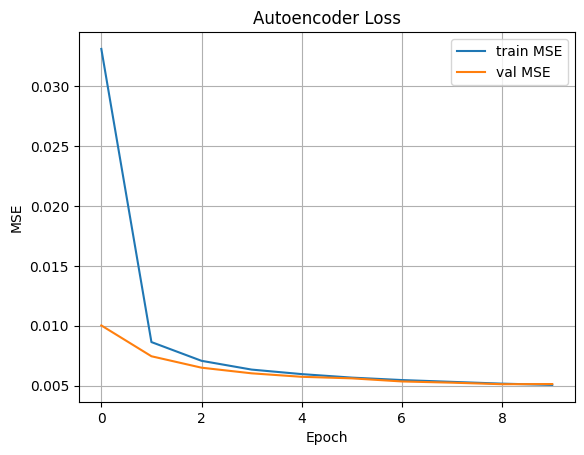

In [ ]:
train_curve, val_curve = [], []
best_val = float("inf")

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss, n = 0.0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    for x, _ in pbar:
        x = x.to(device, non_blocking=True)
        x_in = add_noise(x, NOISE_STD)

        opt.zero_grad()
        x_hat = model(x_in)
        loss = crit(x_hat, x)
        loss.backward()
        opt.step()

        running_loss += loss.item() * x.size(0)
        n += x.size(0)

        pbar.set_postfix({"batch_loss": loss.item()})

    tr_loss = running_loss / n
    va_loss = evaluate(val_loader, NOISE_STD)

    train_curve.append(tr_loss)
    val_curve.append(va_loss)

    print(f"Epoch {epoch:02d} | train MSE: {tr_loss:.4f} | val MSE: {va_loss:.4f}")

    # Lưu best model
    if va_loss < best_val:
        best_val = va_loss
        torch.save(model.state_dict(), ckpt_name)

# plot learning curves
plt.figure()
plt.plot(train_curve, label="train MSE")
plt.plot(val_curve, label="val MSE")
plt.title("Autoencoder Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10432\4269489578.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_name, map_location=de

 (best val MSE = 0.0051)


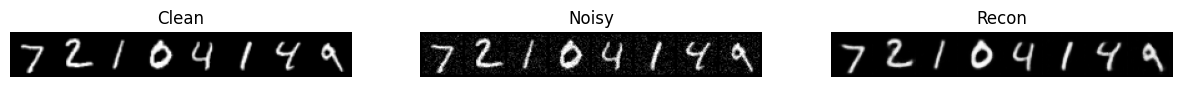

In [ ]:
if os.path.exists(ckpt_name):
    model.load_state_dict(torch.load(ckpt_name, map_location=device))
    model.to(device)
    print(f" (best val MSE = {best_val:.4f})")
else:
    print("Checkpoint chưa tồn tại, dùng model hiện tại.")

show_reconstruction(num_images=8, noise_std=NOISE_STD)